# Cyanobacteria Toxicity Classification Notebook with Cross-Validation

## 1. Setup & Configuration

In [1]:
import os
from datetime import date
import math
import subprocess
import yaml
import pandas as pd
import torch
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from src.config_utils import load_config
from torch.optim.lr_scheduler import OneCycleLR
from PIL import Image
import torch.nn.functional as F
import copy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms as T
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Chargement de la config
config = load_config(path='../configs/config_finetune_resnet18.yaml')

# Répertoires de sortie
FIG_OUT = os.path.join('..', 'outputs', 'figures', 'Switzerland', 'finetune_resnet18')
os.makedirs(FIG_OUT, exist_ok=True)

# Génération du Run ID : date + commit Git
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)


Run ID : 2025-07-25_f0d6835


## 2. Data Preparation

In [2]:
# Transforms avec RandomErasing pour dropout spatial
data_cfg = config['augmentation']

train_transform = T.Compose([
    # 1) Crop aléatoire + scale varié
    T.RandomResizedCrop(size=tuple(data_cfg['resize']),
                        scale=(0.8, 1.0)),
    # 2) Flips horizontal + vertical
    T.RandomHorizontalFlip(p=0.5 if data_cfg['horizontal_flip'] else 0.0),
    T.RandomVerticalFlip(p=0.5 if data_cfg['vertical_flip'] else 0.0),
    # 3) Rotation légère
    T.RandomRotation(degrees=data_cfg['rotation']),
    # 4) Variation colorimétrique
    T.ColorJitter(brightness=data_cfg['color_jitter']['brightness'],
                  contrast=  data_cfg['color_jitter']['contrast'],
                  saturation=data_cfg['color_jitter']['saturation'],
                  hue=       data_cfg['color_jitter']['hue']),
    # 5) Passage en tenseur + normalisation
    T.ToTensor(),
    T.Normalize(mean=data_cfg['normalization']['mean'],
                std= data_cfg['normalization']['std']),
    # 6) Masquage partiel (Random Erasing)
    T.RandomErasing(p=data_cfg['random_erasing']['p'],
                    scale=tuple(data_cfg['random_erasing']['scale']),
                    ratio=tuple(data_cfg['random_erasing']['ratio']))
])

val_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'],
                         std=data_cfg['normalization']['std'])
])


In [3]:
# Chargement du dataset et Stratified K-Fold
dataset = datasets.ImageFolder(
    root=os.path.join('..', config['data']['path']),
    transform=train_transform
)
targets = np.array(dataset.targets)


paths = [path for path, _ in dataset.samples]
groups = [os.path.basename(p).split('_')[0] for p in paths]

df = pd.DataFrame({'target': targets, 'group': groups})
groups_per_class = df.groupby('target')['group'].nunique().to_dict()
n_souches_0 = groups_per_class.get(0, 0)
n_souches_1 = groups_per_class.get(1, 0)
print(f"{n_souches_0} souches non‑toxiques, {n_souches_1} souches toxiques.")

n_splits = min(
    df.groupby('target')['group'].nunique().min(),
    5
)

print(f"Utilisation de n_splits = {n_splits}")

sgkf = StratifiedGroupKFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=42
)

valid_folds = []
for fold, (train_idx, val_idx) in enumerate(
        sgkf.split(np.zeros(len(targets)), targets, groups)
    ):
    # on skippe les folds mono‑classe en validation
    if len(np.unique(targets[val_idx])) < 2:
        print(f"Skip fold {fold+1} (mono‑classe en val)")
        continue
    valid_folds.append((fold, train_idx, val_idx))

print(f"{len(valid_folds)} folds valides sur {n_splits}")

9 souches non‑toxiques, 8 souches toxiques.
Utilisation de n_splits = 5
Skip fold 2 (mono‑classe en val)
Skip fold 5 (mono‑classe en val)
3 folds valides sur 5


## 3. Model Definition

In [4]:
# === EarlyStopping utility ===
class EarlyStopping:
    def __init__(self, patience=3, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


In [5]:
# Définition du modèle, critère et optimizer
device = torch.device(config['training']['device'])
model = models.resnet18(
    weights=ResNet18_Weights.DEFAULT if config['model']['pretrained'] else None
)

# 1) Tout gèlé
for param in model.parameters():
    param.requires_grad = False

# 2) Nouvelle tête (dropout léger)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs, config['model']['num_classes'])
)

model = model.to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [6]:
def train_and_eval_fold(fold, train_idx, val_idx):
    # 1) Préparer DataLoaders avec train_idx / val_idx
    train_subset = Subset(dataset, train_idx)
    val_dataset_full = datasets.ImageFolder(
        root=os.path.join('..', config['data']['path']),
        transform=val_transform
    )
    val_subset = Subset(val_dataset_full, val_idx)

    train_loader = DataLoader(
        train_subset, batch_size=config['data']['batch_size'],
        shuffle=True, num_workers=config['data']['num_workers']
    )
    val_loader   = DataLoader(
        val_subset,   batch_size=config['data']['batch_size'],
        shuffle=False, num_workers=config['data']['num_workers']
    )

    # 2) Réinitialiser le modèle
    model = models.resnet18(
        weights=ResNet18_Weights.DEFAULT if config['model']['pretrained'] else None
    )

    model = model.to(device)


    # 3) Entraînement en Phase 1 & Phase 2
    history = {'train_loss': [], 'val_loss': []}
    num_epochs = config['training']['epochs']
    warmup_epochs = 5

    ### PHASE 1 : warm‑up de la tête seule ###
    print("=== Phase 1 : warm‑up de la tête seule (5 epochs) ===")

    # 1) Geler tout sauf la tête
    for name, param in model.named_parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    # 2) Optimiseur & scheduler pour la tête
    optimizer = optim.AdamW(
        model.fc.parameters(),
        lr=1e-3,  # LR plus élevé pour la tête
        weight_decay=float(config['training']['weight_decay'])
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
    )

    # 3) Boucle warm‑up
    for epoch in range(1, warmup_epochs+1):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Warmup Epoch {epoch}/{warmup_epochs} - Train"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # --- VAL ---
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Warmup Epoch {epoch}/{warmup_epochs} - Val"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val += loss.item() * inputs.size(0)
        val_loss = running_val / len(val_loader.dataset)
        history['val_loss'].append(val_loss)

        scheduler.step(val_loss)
        print(f"Warmup Epoch {epoch} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # --- PHASE 2 : fine‑tuning layer4 + tête + OneCycleLR + MixUp/CutMix ---
    print("=== Phase 2 : fine‑tuning layer4 + tête (up to {} epochs) ===".format(num_epochs))

    # 1) Débloquer layer4 + tête
    for name, param in model.named_parameters():
        if name.startswith("layer4") or name.startswith("fc"):
            param.requires_grad = True

    # 2) Optimiseur à deux groupes
    base_lr = float(config['training']['learning_rate'])
    optimizer = torch.optim.AdamW([
        {"params": model.layer4.parameters(), "lr": base_lr * 0.1},
        {"params": model.fc.parameters(),    "lr": base_lr},
    ], weight_decay=float(config['training']['weight_decay']))

    # 3) OneCycleLR scheduler
    steps_per_epoch = len(train_loader)
    total_epochs = num_epochs - warmup_epochs
    scheduler = OneCycleLR(
        optimizer,
        max_lr=base_lr,
        epochs=total_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=float(config['training']['pct_start']),
        anneal_strategy='cos'
    )

    # 4) EarlyStopping inchangé
    early_stopper = EarlyStopping(patience=3, min_delta=1e-4)

    # 5) Paramètres MixUp/CutMix
    mixup_alpha = float(config['training']['mixup_alpha'])
    mixup_prob  = float(config['training']['mixup_prob'])
    use_cutmix  = bool(config['training']['use_cutmix'])

    # 6) Boucle fine‑tuning
    for epoch in range(warmup_epochs+1, num_epochs+1):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Train"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Décision unique de mix
            do_mix = (np.random.rand() < mixup_prob)
            if do_mix:
                lam = np.random.beta(mixup_alpha, mixup_alpha)
                idx = torch.randperm(inputs.size(0)).to(device)

                if use_cutmix:
                    # -- CutMix --
                    W, H = inputs.size(3), inputs.size(2)
                    cx = np.random.randint(W); cy = np.random.randint(H)
                    w = int(W * np.sqrt(1-lam)); h = int(H * np.sqrt(1-lam))
                    x0, x1 = max(cx-w//2,0), min(cx+w//2, W)
                    y0, y1 = max(cy-h//2,0), min(cy+h//2, H)
                    inputs[:, :, y0:y1, x0:x1] = inputs[idx, :, y0:y1, x0:x1]
                else:
                    # -- MixUp --
                    inputs = lam * inputs + (1 - lam) * inputs[idx]

            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss cohérente avec le mix
            if do_mix:
                loss = lam * criterion(outputs, labels) \
                     + (1 - lam) * criterion(outputs, labels[idx])
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * inputs.size(0)


        train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # — Validation (inchangé) —
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                running_val += criterion(outputs, labels).item() * inputs.size(0)
        val_loss = running_val / len(val_loader.dataset)
        history['val_loss'].append(val_loss)

        if early_stopper(val_loss):
            print(f"Early stopping à l'epoch {epoch}")
            break

        print(f"Epoch {epoch}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # 4) Évaluation finale
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            logits  = model(inputs)
            probs   = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            preds   = (probs >= 0.5).astype(int)  # ou votre seuil optimal
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)

    # 5) Calcul des métriques
    report = classification_report(
        y_true, y_pred, labels=[0,1], output_dict=True, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    roc_auc = roc_auc_score(y_true, y_prob)
    ap      = average_precision_score(y_true, y_prob)

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    return {
        'fold': fold+1,
        'history': history,
        'report': report,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'average_precision': ap,
        'y_true' : y_true,
        'y_pred' : y_pred,
        'y_prob' : y_prob,
        'best_threshold': best_threshold,
        'best_idx': best_idx
    }

## 4. Training Loop

In [7]:
results = []
for i, (fold, train_idx, val_idx) in enumerate(valid_folds):
    print(f"\n=== Training fold {fold+1} ({i+1}/{len(valid_folds)}) ===")
    res = train_and_eval_fold(fold, train_idx, val_idx)
    print(f"Fold {res['fold']} — ROC AUC: {res['roc_auc']:.3f} — AP: {res['average_precision']:.3f}")
    print(pd.DataFrame(res['report']).T[['precision','recall','f1-score','support']])
    results.append(res)
    dir_path = f"../outputs/checkpoints/Switzerland/finetune_resnet18/cross-validation/{run_id}"
    os.makedirs(dir_path, exist_ok=True)
    model_path = os.path.join(dir_path, f"model_fold{fold+1}.pth")
    torch.save(model.state_dict(), model_path)

    print(f"Seuil optimal (max F1) = {res['best_threshold']:.3f}")

# Moyennes et écart‑types
roc_aucs = [r['roc_auc'] for r in results]
aps      = [r['average_precision'] for r in results]
print(f"\nMoyenne ROC AUC: {np.mean(roc_aucs):.3f} ± {np.std(roc_aucs):.3f}")
print(f"Moyenne AP      : {np.mean(aps):.3f} ± {np.std(aps):.3f}")



=== Training fold 1 (1/3) ===
=== Phase 1 : warm‑up de la tête seule (5 epochs) ===


Warmup Epoch 1/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Warmup Epoch 1 — Train Loss: 3.6833 — Val Loss: 2.8572


Warmup Epoch 2/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


Warmup Epoch 2 — Train Loss: 2.1692 — Val Loss: 2.7933


Warmup Epoch 3/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Warmup Epoch 3 — Train Loss: 1.9385 — Val Loss: 2.9190


Warmup Epoch 4/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Warmup Epoch 4 — Train Loss: 1.7556 — Val Loss: 3.0295


Warmup Epoch 5/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Warmup Epoch 5 — Train Loss: 1.7209 — Val Loss: 3.1647
=== Phase 2 : fine‑tuning layer4 + tête (up to 20 epochs) ===


Epoch 6/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 6/20 — Train Loss: 1.6857 — Val Loss: 3.3546


Epoch 7/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


Epoch 7/20 — Train Loss: 1.6544 — Val Loss: 3.2898


Epoch 8/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Epoch 8/20 — Train Loss: 1.5113 — Val Loss: 2.8664


Epoch 9/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 9/20 — Train Loss: 1.4534 — Val Loss: 2.7936


Epoch 10/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 10/20 — Train Loss: 1.4644 — Val Loss: 3.1271


Epoch 11/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 11/20 — Train Loss: 1.4424 — Val Loss: 3.0660


Epoch 12/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 12/20 — Train Loss: 1.3837 — Val Loss: 2.7360


Epoch 13/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 13/20 — Train Loss: 1.3116 — Val Loss: 3.2632


Epoch 14/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 14/20 — Train Loss: 1.3656 — Val Loss: 2.7973


Epoch 15/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]

Early stopping à l'epoch 15


Fold 1 — ROC AUC: 0.375 — AP: 0.600
              precision    recall  f1-score    support
0              0.348837  0.833333  0.491803  36.000000
1              0.538462  0.111111  0.184211  63.000000
accuracy       0.373737  0.373737  0.373737   0.373737
macro avg      0.443649  0.472222  0.338007  99.000000
weighted avg   0.469507  0.373737  0.296062  99.000000
Seuil optimal (max F1) = 0.003

=== Training fold 3 (2/3) ===
=== Phase 1 : warm‑up de la tête seule (5 epochs) ===


Warmup Epoch 1/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 1 — Train Loss: 3.8357 — Val Loss: 2.4330


Warmup Epoch 2/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Warmup Epoch 2 — Train Loss: 2.2209 — Val Loss: 2.1576


Warmup Epoch 3/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 3 — Train Loss: 2.0505 — Val Loss: 1.9986


Warmup Epoch 4/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Warmup Epoch 4 — Train Loss: 1.9777 — Val Loss: 1.8801


Warmup Epoch 5/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Warmup Epoch 5 — Train Loss: 1.9235 — Val Loss: 1.7969
=== Phase 2 : fine‑tuning layer4 + tête (up to 20 epochs) ===


Epoch 6/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 6/20 — Train Loss: 1.9078 — Val Loss: 1.7845


Epoch 7/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 7/20 — Train Loss: 1.7936 — Val Loss: 1.6665


Epoch 8/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 8/20 — Train Loss: 1.6608 — Val Loss: 1.6663


Epoch 9/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 9/20 — Train Loss: 1.5959 — Val Loss: 1.6505


Epoch 10/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 10/20 — Train Loss: 1.5238 — Val Loss: 1.5545


Epoch 11/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 11/20 — Train Loss: 1.5092 — Val Loss: 1.5478


Epoch 12/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 12/20 — Train Loss: 1.5133 — Val Loss: 1.5463


Epoch 13/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Epoch 13/20 — Train Loss: 1.4417 — Val Loss: 1.5915


Epoch 14/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 14/20 — Train Loss: 1.4258 — Val Loss: 1.5019


Epoch 15/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 15/20 — Train Loss: 1.3954 — Val Loss: 1.4949


Epoch 16/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 16/20 — Train Loss: 1.3898 — Val Loss: 1.4920


Epoch 17/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 17/20 — Train Loss: 1.4202 — Val Loss: 1.4955


Epoch 18/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.97s/it]


Epoch 18/20 — Train Loss: 1.3826 — Val Loss: 1.4742


Epoch 19/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 19/20 — Train Loss: 1.3376 — Val Loss: 1.4779


Epoch 20/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]

Epoch 20/20 — Train Loss: 1.3572 — Val Loss: 1.4945


Fold 3 — ROC AUC: 0.911 — AP: 0.826
              precision    recall  f1-score     support
0              0.868132  0.887640  0.877778   89.000000
1              0.795918  0.764706  0.780000   51.000000
accuracy       0.842857  0.842857  0.842857    0.842857
macro avg      0.832025  0.826173  0.828889  140.000000
weighted avg   0.841826  0.842857  0.842159  140.000000
Seuil optimal (max F1) = 0.401

=== Training fold 4 (3/3) ===
=== Phase 1 : warm‑up de la tête seule (5 epochs) ===


Warmup Epoch 1/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 1 — Train Loss: 3.8854 — Val Loss: 2.2519


Warmup Epoch 2/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 2 — Train Loss: 2.3094 — Val Loss: 2.0792


Warmup Epoch 3/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Warmup Epoch 3 — Train Loss: 2.0885 — Val Loss: 2.0143


Warmup Epoch 4/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Warmup Epoch 4 — Train Loss: 1.9852 — Val Loss: 1.9131


Warmup Epoch 5/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Warmup Epoch 5 — Train Loss: 1.8852 — Val Loss: 1.8993
=== Phase 2 : fine‑tuning layer4 + tête (up to 20 epochs) ===


Epoch 6/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 6/20 — Train Loss: 1.8833 — Val Loss: 1.8443


Epoch 7/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 7/20 — Train Loss: 1.8099 — Val Loss: 1.8666


Epoch 8/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 8/20 — Train Loss: 1.5863 — Val Loss: 1.9640


Epoch 9/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.94s/it]

Early stopping à l'epoch 9


Fold 4 — ROC AUC: 0.713 — AP: 0.690
              precision    recall  f1-score     support
0              0.756098  0.418919  0.539130   74.000000
1              0.552083  0.841270  0.666667   63.000000
accuracy       0.613139  0.613139  0.613139    0.613139
macro avg      0.654090  0.630094  0.602899  137.000000
weighted avg   0.662281  0.613139  0.597778  137.000000
Seuil optimal (max F1) = 0.550

Moyenne ROC AUC: 0.666 ± 0.221
Moyenne AP      : 0.705 ± 0.093


## 5. Results Visualization

In [8]:
rows = []
for r in results:
    rep = r['report']
    rows.append({
        'fold':        r['fold'],
        'roc_auc':     r['roc_auc'],
        'avg_precision': r['average_precision'],
        'accuracy':    rep['accuracy'],
        'f1_class0':   rep['0']['f1-score'],
        'f1_class1':   rep['1']['f1-score']
    })
df_metrics = pd.DataFrame(rows).set_index('fold')
csv_path = os.path.join(FIG_OUT, f"{run_id}_folds_metrics_report.csv")
df_metrics.to_csv(csv_path, index=True)
print("=== Résumé des métriques par fold ===")
display(df_metrics)
print("\nMoyenne ± écart‑type :")
print(df_metrics.mean().to_frame('mean').join(df_metrics.std().to_frame('std')))


=== Résumé des métriques par fold ===


,roc_auc,avg_precision,accuracy,f1_class0,f1_class1
fold,,,,,
1,0.375220,0.600089,0.373737,0.491803,0.184211
3,0.910773,0.826162,0.842857,0.877778,0.780000
4,0.712570,0.689609,0.613139,0.539130,0.666667



Moyenne ± écart‑type :
                   mean       std
roc_auc        0.666188  0.270772
avg_precision  0.705287  0.113849
accuracy       0.609911  0.234577
f1_class0      0.636237  0.210515
f1_class1      0.543626  0.316379


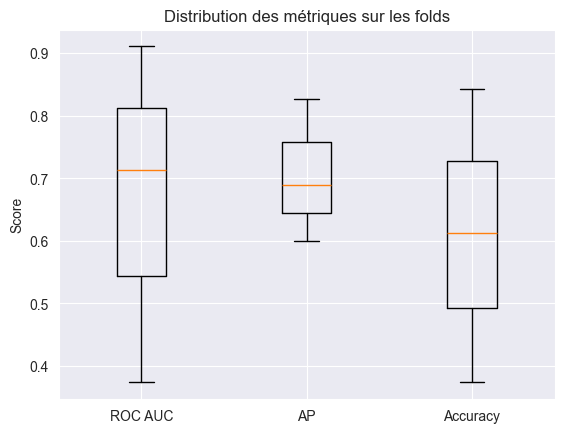

In [9]:
plt.figure()
plt.boxplot([df_metrics['roc_auc'], df_metrics['avg_precision'], df_metrics['accuracy']],
            tick_labels=['ROC AUC','AP','Accuracy'])
plt.title("Distribution des métriques sur les folds")
plt.ylabel("Score")
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_metrics.png"), dpi=300)
plt.show()


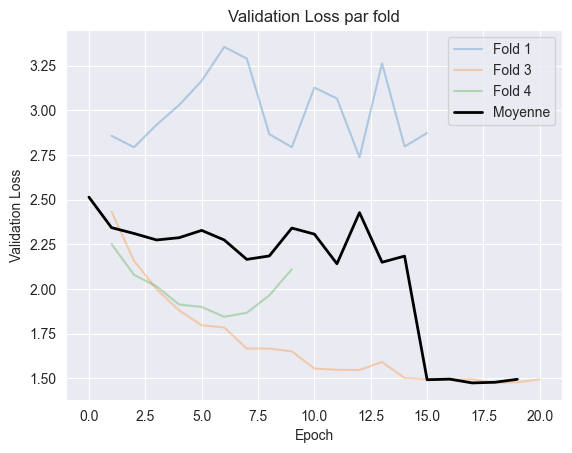

In [10]:
plt.figure()
for r in results:
    epochs = range(1, len(r['history']['val_loss'])+1)
    plt.plot(epochs, r['history']['val_loss'], alpha=0.3, label=f"Fold {r['fold']}")
# moyenne
mean_val = pd.DataFrame([r['history']['val_loss'] for r in results]).mean()
epochs = mean_val.index
plt.plot(epochs, mean_val, color='black', linewidth=2, label='Moyenne')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss par fold")
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_loss.png"), dpi=300)
plt.show()


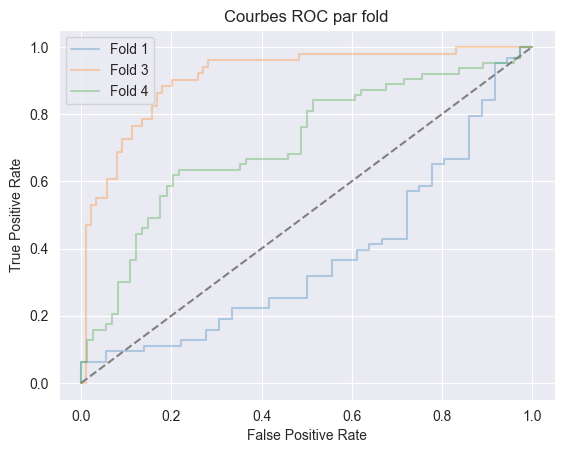

In [11]:
plt.figure()
for r in results:
    y_true = r['y_true']
    y_prob = r['y_prob']
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, alpha=0.3, label=f"Fold {r['fold']}")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC par fold")
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_roc.png"), dpi=300)
plt.show()


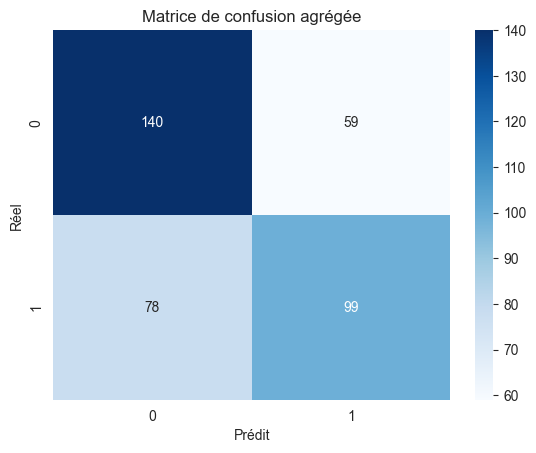

In [12]:
cm_sum = sum(r['confusion_matrix'] for r in results)
plt.figure()
sns.heatmap(cm_sum, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion agrégée")
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_aggregate_confusion_matrix.png"), dpi=300)
plt.show()


## 6. Save Model & Config

In [13]:
# Sauvegarde du modèle et de la config
os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet18', exist_ok=True)
torch.save(model.state_dict(),
           f'../outputs/checkpoints/Switzerland/finetune_resnet18/{run_id}_model.pth')

os.makedirs('../outputs/configs/Switzerland', exist_ok=True)
with open(f'../outputs/configs/Switzerland/{run_id}_config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)

print('Entraînement terminé. Modèle et config enregistrés.')


Entraînement terminé. Modèle et config enregistrés.
